In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
sns.set_context('talk')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

In [2]:
log_directory = '../../../data/raw/logs/'

In [3]:
def get_log_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, dir_path + "/" + filename))
    return result

In [4]:
def get_kafka_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit,  dir_path + "/" + filename))
    return result

In [5]:
def get_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit, dir_path + "/" + filename))
    return result

In [6]:
def get_kafka_consumer_files(dir_path, pattern):
    result = []
    for filename in os.listdir(dir_path):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            if data_size:
                result.append((data_size, dir_path + "/" + filename))
    return result

In [7]:
def create_kafka_producer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [8]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [9]:
def create_kafka_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [10]:
def producer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt/10"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["event"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
        variant_dfs["processing"] = create_rembrandt_dataframe(get_log_files(directory + variant, "rembrandt_producer_(\d+)_(\d+)_(\d+)_processing_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    kafka_dfs = {}
    kafka_dfs["tp"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_throughput.csv"))
    kafka_dfs["event"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_event_latency_timeline.csv"), skiprows=1)
    kafka_dfs["processing"] = create_kafka_producer_dataframe(get_kafka_files(directory + "kafka", "kafka_producer_(\d+)_(\d+)_processing_latency_timeline.csv"), skiprows=1)
    result["kafka"] = kafka_dfs
    return result

In [11]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

In [12]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [13]:
def consumer_dfs(directory):
    result = {}
    for variant in ["exclusive", "exclusive_opt", "concurrent", "concurrent_opt"]:
        variant_dfs = {}
        variant_dfs["tp"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_(\d+)_throughput.csv"))
        variant_dfs["e2e"] = create_rembrandt_consumer_dataframe(get_consumer_files(directory + variant, "rembrandt_consumer_(\d+)_(\d+)_e2e_latency_timeline.csv"), skiprows=1)
        result[variant] = variant_dfs
    
    kafka_dfs = {}
    kafka_dfs["tp"] = create_kafka_consumer_dataframe(get_kafka_consumer_files(directory + "kafka", "kafka_consumer_(\d+)_throughput.csv"))
    kafka_dfs["e2e"] = create_kafka_consumer_dataframe(get_kafka_consumer_files(directory + "kafka", "kafka_consumer_(\d+)_e2e_latency_timeline.csv"), skiprows=1)
    result["kafka"] = kafka_dfs
    return result

In [14]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt"][measure],
               dataframes["kafka"][measure]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    df_list[4]["Protocol"] = "Kafka"
    return pd.concat(df_list)

# Identify sustainable throughput

## Kafka Sustainable Throughput

In [15]:
dataframes = consumer_dfs(log_directory + "20200727/e2e/")

In [16]:
dataframes["kafka"]["tp"].mean()

index                    166.000000
Number of Messages      1830.483483
Throughput in MB/s       239.925117
Message Size          131072.000000
dtype: float64

In [17]:
kafka_e2e_df = dataframes["kafka"]["e2e"]
kafka_e2e_df["Rate Limit in MB/s"] = 240

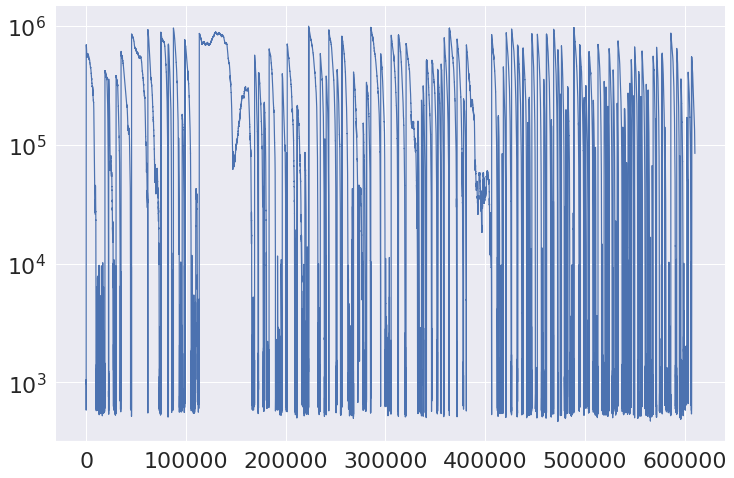

In [57]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
# sns.set(font_scale=2)
sns.set_context('paper')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
# df = dataframes["exclusive"]["processing"][dataframes["exclusive"]["processing"]["Rate Limit in MB/s"] == 3600].pivot(index='index', columns='Rate Limit in MB/s', values="Avg. Latency in us")
ax.plot(kafka_e2e_df["index"], kafka_e2e_df["Latency in us"])
plt.yscale("log")
# plt.savefig("exclusive_75_event_timeline")

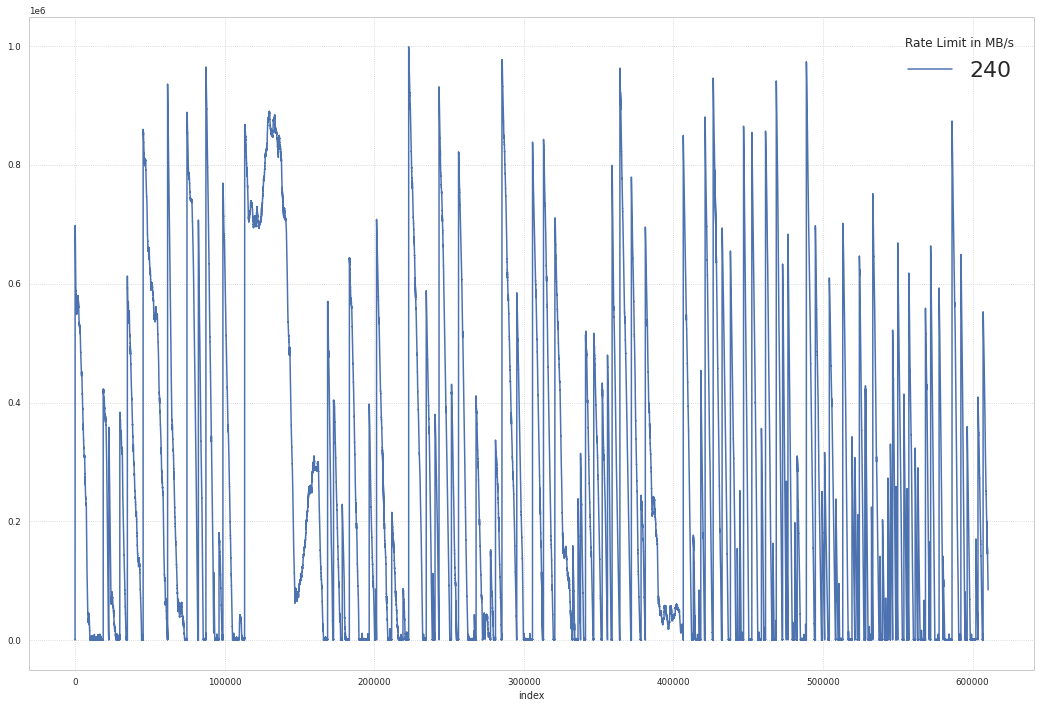

In [33]:
plot_timeseries(kafka_e2e_df, "Latency in us")

## Ghostwriter Sustainable Throughput

In [58]:
dataframes["exclusive"]["e2e"].head()

,index,Latency in us,Message Size in Bytes,Rate Limit in MB/s
0,0,104,131072,3600
1,1,69,131072,3600
2,2,95,131072,3600
3,3,137,131072,3600
4,4,123,131072,3600


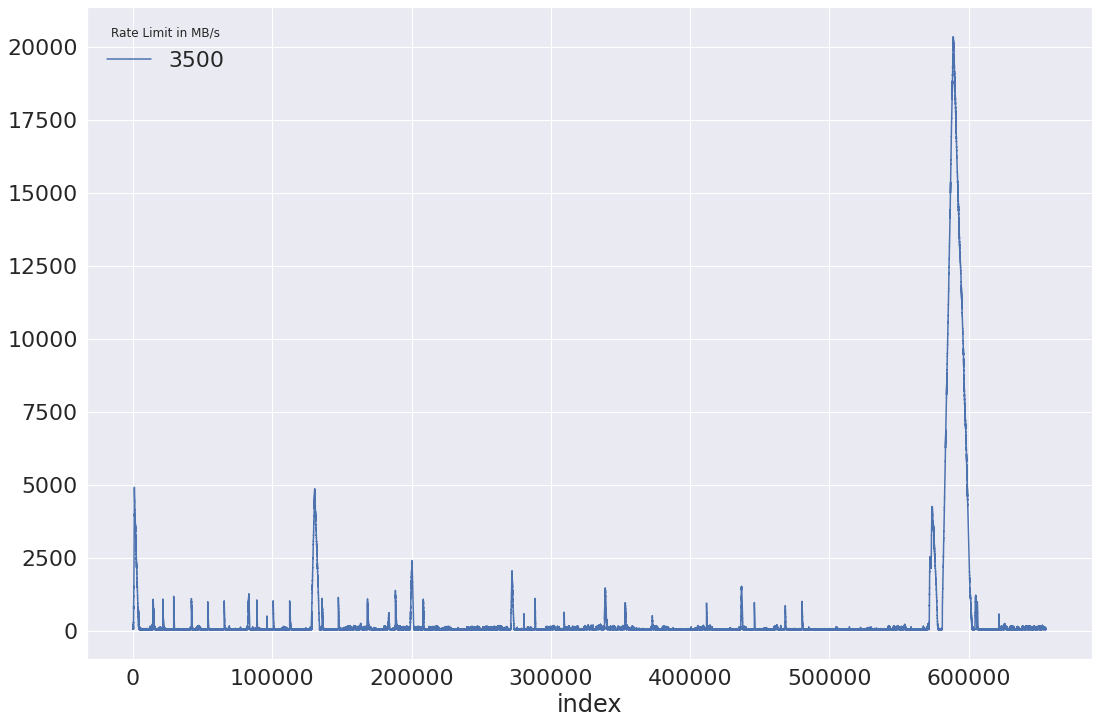

In [84]:
plot_timeseries(dataframes["exclusive"]["e2e"][dataframes["exclusive"]["e2e"]["Rate Limit in MB/s"] <= 3500], "Latency in us")

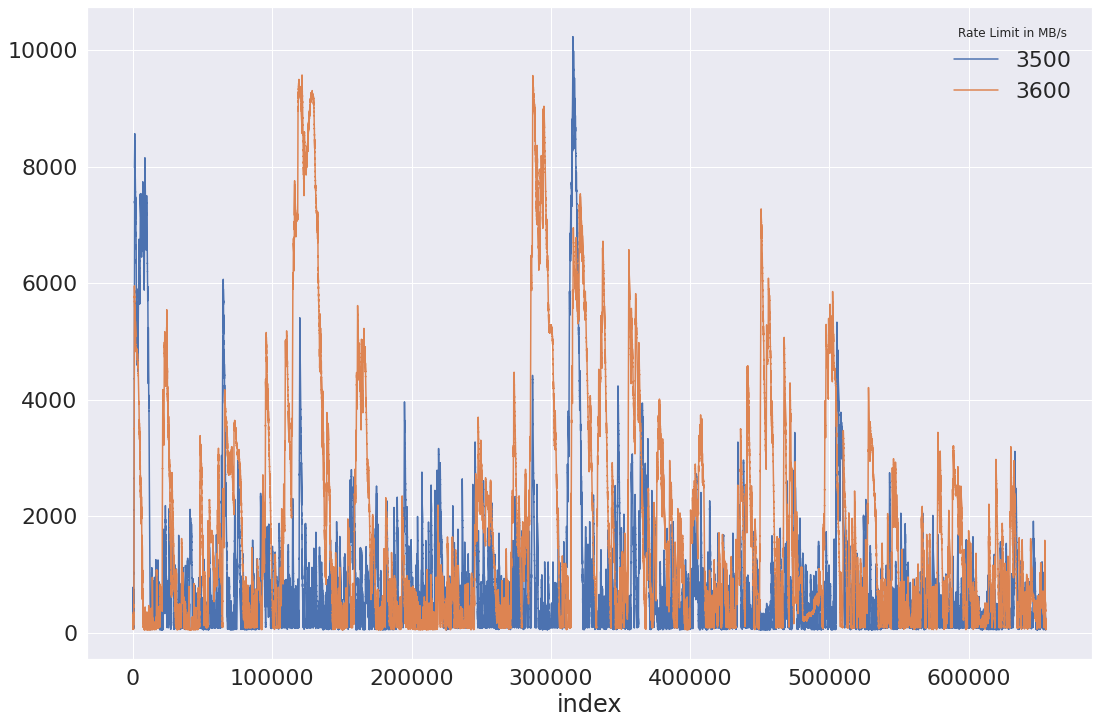

In [62]:
plot_timeseries(dataframes["exclusive_opt"]["e2e"][dataframes["exclusive_opt"]["e2e"]["Rate Limit in MB/s"] <= 3600], "Latency in us")

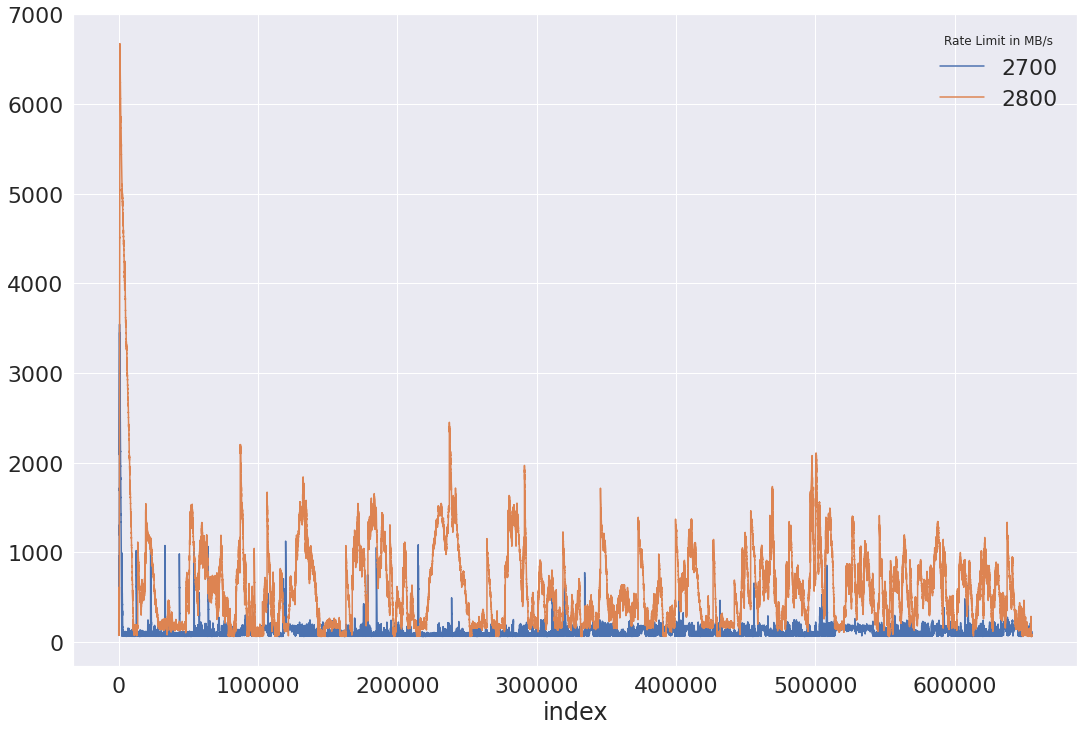

In [65]:
plot_timeseries(dataframes["concurrent"]["e2e"][dataframes["concurrent"]["e2e"]["Rate Limit in MB/s"] <= 2800], "Latency in us")

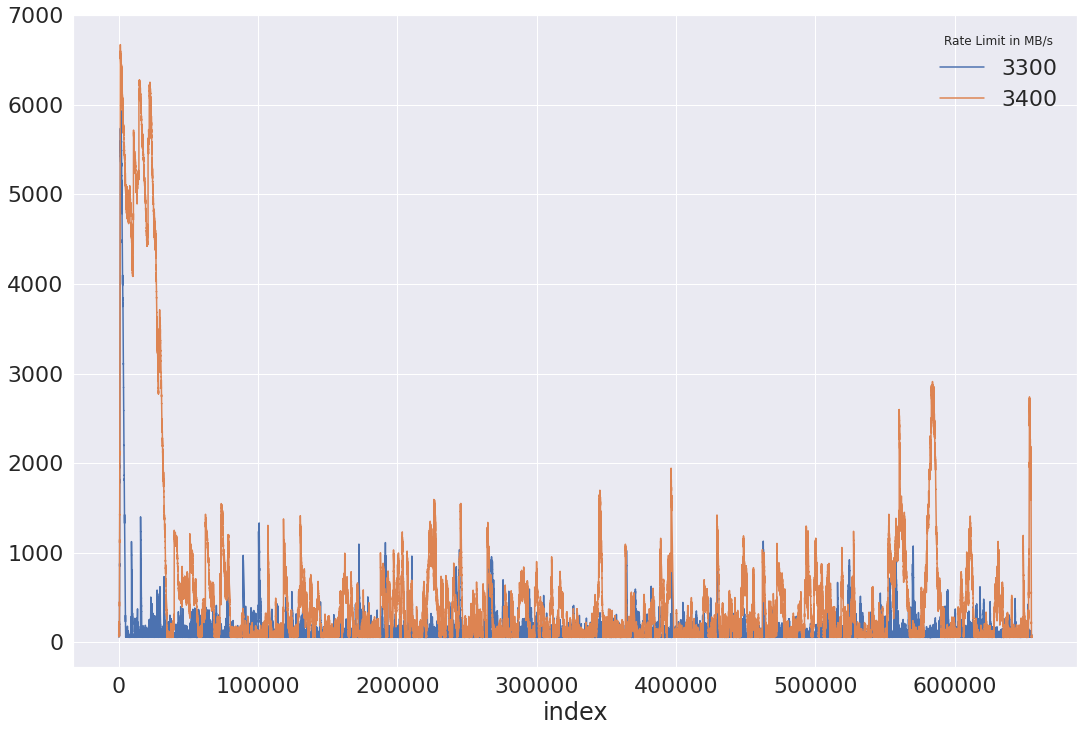

In [66]:
plot_timeseries(dataframes["concurrent_opt"]["e2e"][dataframes["concurrent_opt"]["e2e"]["Rate Limit in MB/s"] <= 3400], "Latency in us")

In [18]:
def filter_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure][dataframes["exclusive"][measure]["Rate Limit in MB/s"] == 3500],
               dataframes["exclusive_opt"][measure][dataframes["exclusive_opt"][measure]["Rate Limit in MB/s"] == 3600],
               dataframes["concurrent"][measure][dataframes["concurrent"][measure]["Rate Limit in MB/s"] == 2800],
               dataframes["concurrent_opt"][measure][dataframes["concurrent_opt"][measure]["Rate Limit in MB/s"] == 3400],
               dataframes["kafka"][measure]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    df_list[4]["Protocol"] = "Kafka"
    return pd.concat(df_list)

In [19]:
max_sust_tps_df = filter_dfs(dataframes, "tp")

<ipython-input-18-b00b36c651ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-18-b00b36c651ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-18-b00b36c651ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

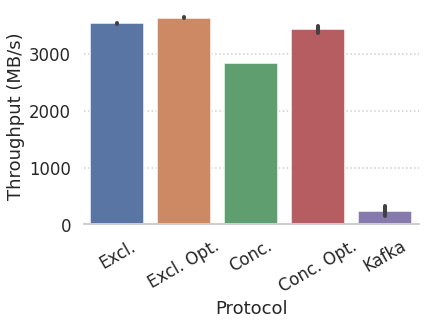

In [21]:
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Throughput in MB/s", hue="Protocol", data=max_sust_tps_df, ci="sd", dodge=False)
sns.despine(left=True)
g.get_legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='center')
g.set_ylabel("Throughput (MB/s)")
g.get_figure().savefig("ghostwriter_e2e_sustainable_throughput.pdf", bbox_inches="tight", dpi=600)

In [25]:
max_e2e_lat_df = filter_dfs(dataframes, "e2e")
max_e2e_lat_df.head()

<ipython-input-16-b00b36c651ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-16-b00b36c651ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-16-b00b36c651ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,index,Latency in us,Message Size,Rate Limit in MB/s,Protocol
0,0,87,131072,3500.0,Excl.
1,1,95,131072,3500.0,Excl.
2,2,113,131072,3500.0,Excl.
3,3,147,131072,3500.0,Excl.
4,4,178,131072,3500.0,Excl.


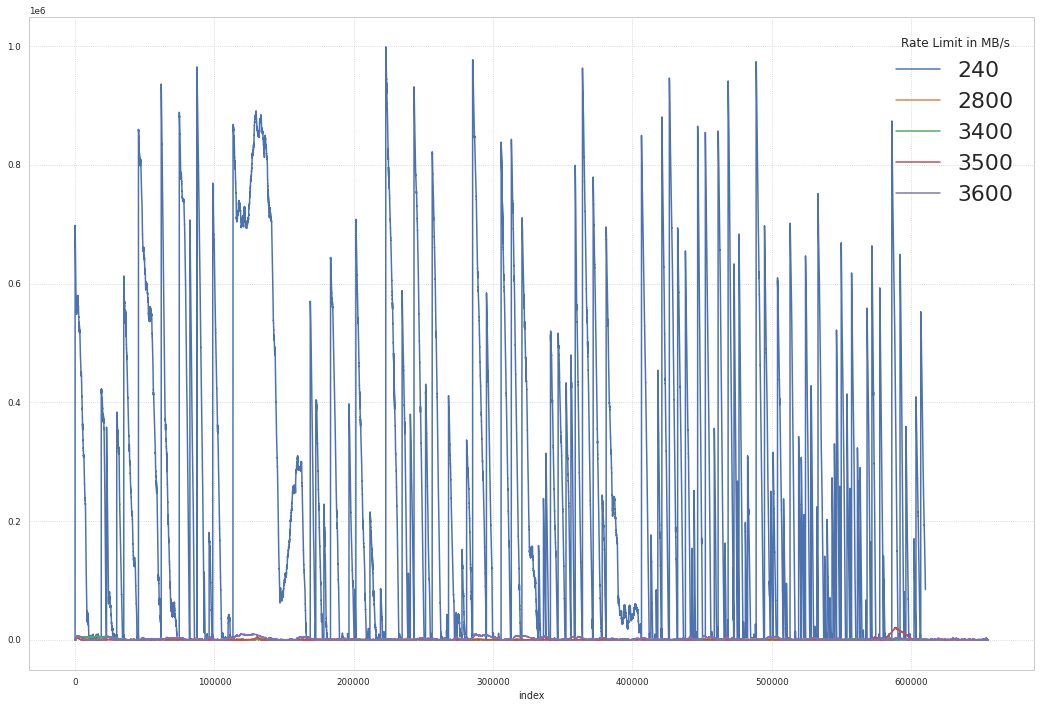

In [81]:
plot_timeseries(max_e2e_lat_df, "Latency in us")

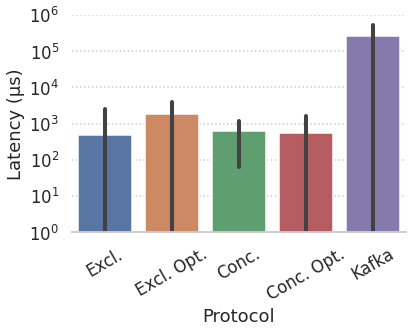

In [26]:
sns.despine(left=True)
g = sns.barplot(x="Protocol", y="Latency in us", hue="Protocol", data=max_e2e_lat_df, ci="sd", dodge=False)
sns.despine(left=True)
g.get_legend().remove()
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='center')
g.set_ylabel("Latency (μs)")
plt.yscale("log")
g.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
g.get_figure().savefig("ghostwriter_e2e_latency_100", bbox_inches="tight", dpi=600)

# Different Load Factors

In [22]:
dataframes_75 = consumer_dfs(log_directory + "20200727/e2e/75/")

In [23]:
def prepare_dfs(dataframes, measure):
    df_list = [dataframes["exclusive"][measure],
               dataframes["exclusive_opt"][measure],
               dataframes["concurrent"][measure],
               dataframes["concurrent_opt"][measure],
               dataframes["kafka"][measure]]
    df_list[0]["Protocol"] = "Excl."
    df_list[1]["Protocol"] = "Excl. Opt."
    df_list[2]["Protocol"] = "Conc."
    df_list[3]["Protocol"] = "Conc. Opt."
    df_list[4]["Protocol"] = "Kafka"
    return pd.concat(df_list)

In [24]:
e2e_lat_75_df = prepare_dfs(dataframes_75, "e2e")

In [25]:
def prepare_plottable(measure):
    df_100 = filter_dfs(consumer_dfs(log_directory + "20200727/e2e/"), measure)
    df_75 = prepare_dfs(consumer_dfs(log_directory + "20200727/e2e/75/"), measure)
    df_50 = prepare_dfs(consumer_dfs(log_directory + "20200727/e2e/50/"), measure)
    df_100["Load Factor"] = "100%"
    df_75["Load Factor"] = "75%"
    df_50["Load Factor"] = "50%"
    return pd.concat([df_100, df_75, df_50])

In [26]:
event_lat_df = prepare_plottable("e2e")

<ipython-input-18-b00b36c651ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[0]["Protocol"] = "Excl."
<ipython-input-18-b00b36c651ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_list[1]["Protocol"] = "Excl. Opt."
<ipython-input-18-b00b36c651ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

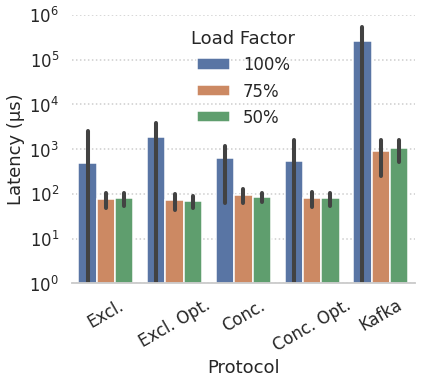

In [27]:
g = sns.catplot(x="Protocol", y="Latency in us", hue="Load Factor", data=event_lat_df, ci="sd", kind="bar",aspect=4./3, legend_out=False)
sns.despine(left=True)
g.set(yscale="log")
for ax in g.axes.flat:
    ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='center')
    ax.set_ylabel("Latency (μs)")
g.savefig("e2e_latency.pdf", bbox_inches="tight", dpi=600)